# Mapping Emotion
### Sentiment Analysis of Fitzgerald’s Novels Using VADER and Cardiff RoBERTa

This notebook analyzes the emotional tone in F. Scott Fitzgerald’s novels using two sentiment analysis models: VADER (a rule-based model) and CardiffNLP’s RoBERTa (a transformer-based model fine-tuned model).

Cleaned, sentence-level text is loaded for each novel. Sentiment scores are computed using both models, aggregated by chapter, and compared to explore how each method captures emotional patterns across the narratives. The results are visualized to highlight trends and differences in sentiment over the course of each book.

## Import Libraries

In [1]:
%run ../notebooks/setup_path.py
from config import *

# Utilities
import re
import requests
import csv
import numpy as np

# Text processing
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('vader_lexicon')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Transformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\Virginia\Python\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## VADER

This section applies the VADER sentiment analyzer to each sentence in the cleaned texts. VADER, part of the NLTK library, is designed to assess sentiment in everyday English, assigning scores for positive, neutral, and negative tone, along with an overall compound score.

The sentiment scores are saved per book and used to compute average sentiment values, offering an initial view of the emotional tone throughout each novel. This provides a foundation for exploring how mood shifts across and within Fitzgerald’s works. 

In [2]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

print("== Sentiment Analysis: VADER ==")

for title in BOOKS:

    clean_path = PROCESSED_DIR / f"{title}-cleaned.txt"
    output_path = VADER_RESULTS_DIR / f"{title}-sentiment-analysis-per-sentence-vader.csv"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    # Read cleaned sentences from file
    with open(clean_path, "r", encoding = "utf-8") as f:
        sentences = [line.strip() for line in f if line.strip()]

    sentiment_data = []
    for sentence in sentences:
        scores = sia.polarity_scores(sentence)
        sentiment_data.append({
            "sentence": sentence,
            "neg": scores["neg"],
            "neu": scores["neu"],
            "pos": scores["pos"],
            "compound": scores["compound"]
        })

    # Save sentiment results to CSV
    with open(output_path, "w", encoding = "utf-8", newline = "") as f:
        writer = csv.DictWriter(f, fieldnames=["sentence", "neg", "neu", "pos", "compound"])
        writer.writeheader()
        writer.writerows(sentiment_data)

    # Calculate average compound score
    avg_score = sum(d["compound"] for d in sentiment_data) / len(sentiment_data) if sentiment_data else 0

    # Determine overall sentiment label
    if avg_score > 0.05:
        label = "Positive"
    elif avg_score < -0.05:
        label = "Negative"
    else:
        label = "Neutral"


    # Output summary
    print(f"\nTitle: {title.replace('-', ' ').title()}")
    print(f"Average Sentiment Score: {avg_score:.2f}")
    print(f"Overall Sentiment Label: {label}")
    print("-" * 60)

== Sentiment Analysis: VADER ==

Title: This Side Of Paradise
Average Sentiment Score: 0.06
Overall Sentiment Label: Positive
------------------------------------------------------------

Title: The Beautiful And Damned
Average Sentiment Score: 0.04
Overall Sentiment Label: Neutral
------------------------------------------------------------

Title: The Great Gatsby
Average Sentiment Score: 0.03
Overall Sentiment Label: Neutral
------------------------------------------------------------


The sentiment analysis shows that all three novels have a slightly positive overall tone. *This Side of Paradise* comes across as a bit more upbeat compared to the other two, which lean closer to neutral. That fits with its youthful and hopeful vibe, while *The Beautiful and Damned* and *The Great Gatsby* feel a bit more calm emotionally.

It’s worth keeping in mind that this kind of sentence-level, lexicon-based analysis can miss some of the complexity, like irony or deeper context. Still, it gives a good general sense of the emotional mood in each book.

Further exploration of sentiment at chapter level may offer deeper insight into how the emotional tone evolves throughout each novel.

In [3]:
def split_into_chapters(text):
    """
    Splits a full text into chapters based on common chapter headings.

    Recognizes patterns like "Chapter 1", "Chapter I", "Chapter One", etc.

    Parameters:
    ----------
        text (str): The full raw text of a book or document.

    Returns:
    ----------
        List[Tuple[str, str]]: A list of tuples, each containing:
            - chapter title (e.g., 'Chapter 1')
            - chapter text (stripped of leading/trailing whitespace)
    """
    chapter_pattern = re.compile(r"(?:^|\n)(chapter [ivxlc\d]+|chapter \w+)", re.IGNORECASE)
    splits = chapter_pattern.split(text)
    chapters = []
    for i in range(1, len(splits), 2):
        chapter_title = splits[i].strip()
        chapter_text = splits[i+1] if i+1 < len(splits) else ""
        chapters.append((chapter_title, chapter_text.strip()))
    return chapters


def chapter_sentiment(chapters):
    """
    Performs sentiment analysis on each chapter based on sentence-level compound scores.

    Aggregates sentence-level sentiment scores into an average score for the chapter
    and assigns an overall sentiment label.

    Parameters:
    ----------
        chapters (List[Tuple[str, str]]): List of (chapter_title, chapter_text) pairs.

    Returns:
    ----------
        List[Dict]: A list of dictionaries for each chapter containing:
            - 'chapter': title of the chapter
            - 'avg_compound': average compound sentiment score
            - 'num_sentences': number of sentences in the chapter
            - 'sentiment_label': overall sentiment label ('Positive', 'Negative', 'Neutral')
    """
    chapter_scores = []
    for title, text in chapters:
        sentences = sent_tokenize(text)
        scores = [sia.polarity_scores(s)["compound"] for s in sentences if s.strip()]
        avg_score = sum(scores) / len(scores) if scores else 0

        if avg_score > 0.05:
            label = "Positive"
        elif avg_score < -0.05:
            label = "Negative"
        else:
            label = "Neutral"

        chapter_scores.append({
            "chapter": title,
            "avg_compound": avg_score,
            "num_sentences": len(sentences),
            "sentiment_label": label
        })
    return chapter_scores

In [4]:
print("== Sentiment Analysis Per Chapter: VADER ==")

for title in BOOKS:

    clean_path = PROCESSED_DIR / f"{title}-cleaned.txt"
    output_path = VADER_RESULTS_DIR / f"{title}-sentiment-analysis-per-chapter-vader.csv"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    with open(clean_path, "r", encoding="utf-8") as f:
        text = f.read()

    chapters = split_into_chapters(text)
    chapter_scores = chapter_sentiment(chapters)
    
    # Save results
    with open(output_path, "w", encoding = "utf-8", newline = "") as f:
        writer = csv.DictWriter(f, fieldnames=["chapter", "avg_compound", "num_sentences", "sentiment_label"])
        writer.writeheader()
        writer.writerows(chapter_scores)

    # Output summary
    print(f"\nTitle: {title.replace('-', ' ').title()}\n")
    for ch in chapter_scores:
        print(f"{ch['chapter']:<12}: Average Compound Sentiment: {ch['avg_compound']:.2f} — {ch['sentiment_label']}")
    print("-" * 60)

== Sentiment Analysis Per Chapter: VADER ==

Title: This Side Of Paradise

CHAPTER I   : Average Compound Sentiment: 0.11 — Positive
CHAPTER II  : Average Compound Sentiment: 0.09 — Positive
CHAPTER III : Average Compound Sentiment: 0.01 — Neutral
CHAPTER IV  : Average Compound Sentiment: 0.05 — Positive
CHAPTER I   : Average Compound Sentiment: 0.10 — Positive
CHAPTER II  : Average Compound Sentiment: 0.04 — Neutral
CHAPTER III : Average Compound Sentiment: 0.05 — Positive
CHAPTER IV  : Average Compound Sentiment: -0.02 — Neutral
CHAPTER V   : Average Compound Sentiment: 0.01 — Neutral
------------------------------------------------------------

Title: The Beautiful And Damned

CHAPTER I   : Average Compound Sentiment: 0.13 — Positive
CHAPTER II  : Average Compound Sentiment: 0.09 — Positive
CHAPTER III : Average Compound Sentiment: 0.06 — Positive
CHAPTER I   : Average Compound Sentiment: 0.05 — Neutral
CHAPTER II  : Average Compound Sentiment: 0.02 — Neutral
CHAPTER III : Average C

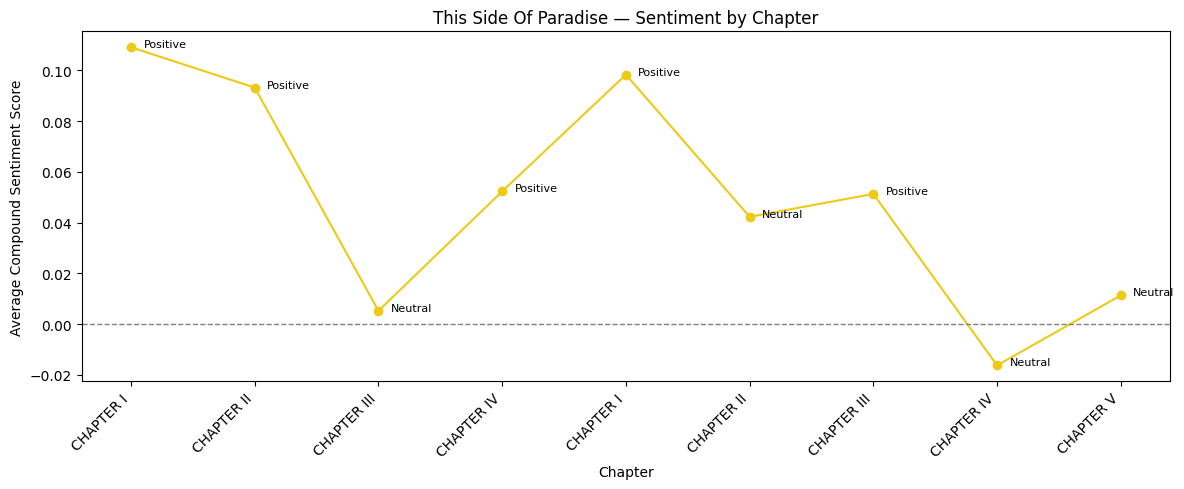

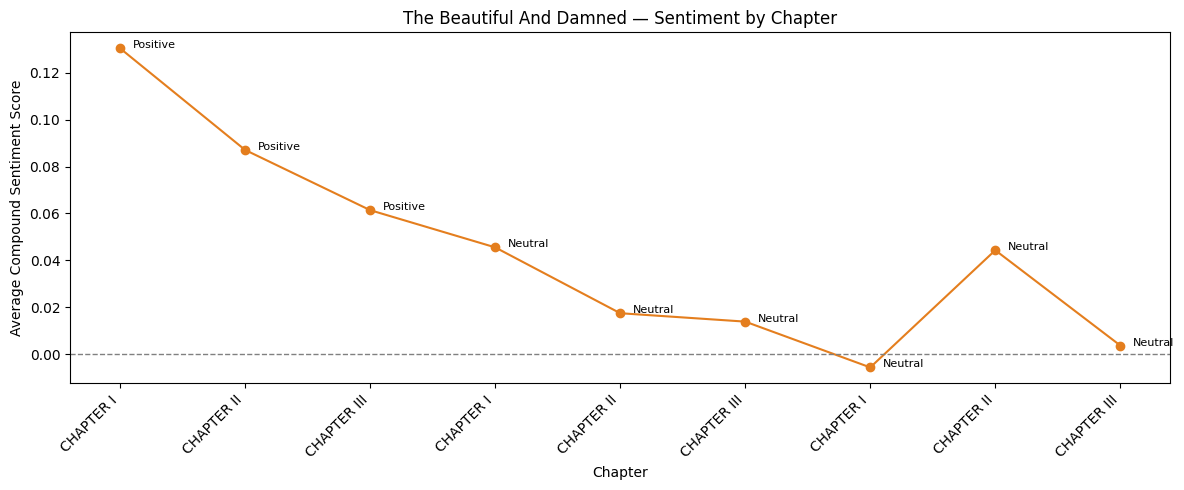

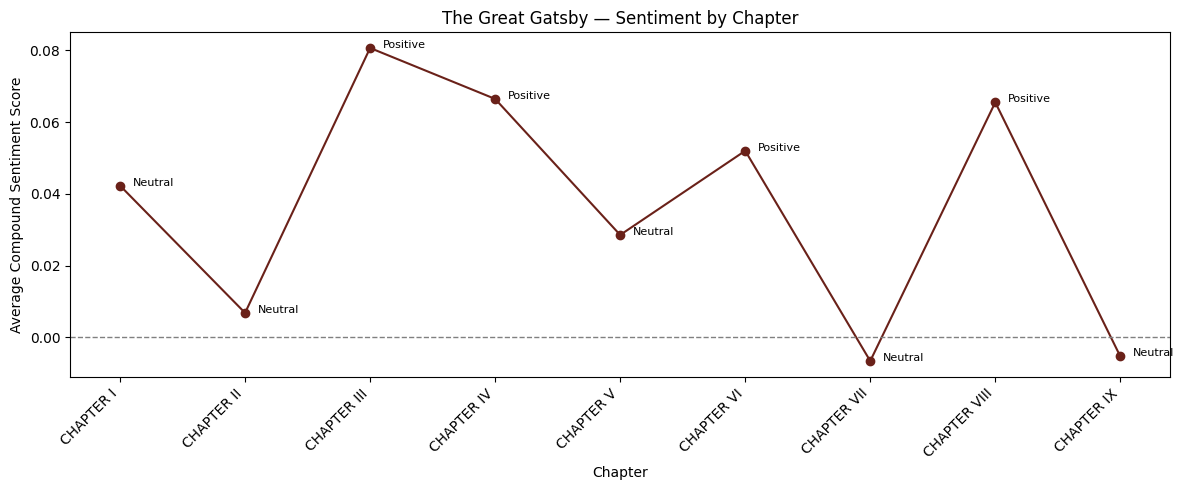

In [5]:
colors = ["#eeca16", "#e47e1e", "#6a2119"]

for title, color in zip(BOOKS, colors):

    csv_path = VADER_RESULTS_DIR / f"{title}-sentiment-analysis-per-chapter-vader.csv"
    figure_path = VADER_FIGURES_DIR / f"{title}-sentiment-analysis-per-chapter-vader.png"

    if not clean_path.exists():
        print(f"File not found: {clean_path}")
        continue

    chapters = []
    scores = []
    labels = []

    # Load CSV data
    with open(csv_path, "r", encoding = "utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            chapters.append(row["chapter"])
            scores.append(float(row["avg_compound"]))
            labels.append(row["sentiment_label"])

    # Clean book title
    pretty_title = title.replace("-", " ").title()

    # Plot
    plt.figure(figsize = (12, 5))
    plt.plot(scores, marker = "o", color = color)

    for i, label in enumerate(labels):
        plt.text(i + 0.1, scores[i], label, fontsize = 8)

    plt.axhline(0, color = "gray", linestyle = "--", linewidth = 1)
    plt.xticks(ticks = range(len(chapters)), labels = chapters, rotation = 45, ha = "right")
    plt.title(f"{pretty_title} — Sentiment by Chapter")
    plt.xlabel("Chapter")
    plt.ylabel("Average Compound Sentiment Score")
    plt.tight_layout()
    plt.savefig(figure_path)

Looking at the sentiment by chapter, *This Side of Paradise* generally stays on the positive side, especially in the beginning, though some chapters later on are more neutral. *The Beautiful and Damned* starts off positive but then mostly stays neutral. *The Great Gatsby* goes back and forth between neutral and a little positive, with a few chapters dropping back to neutral. Overall, the feelings in the books switch between a bit of positivity and neutral, matching how the stories go up and down.